In [1]:
import re
import urllib
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython import display
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(113145)

# Single RNN cell test

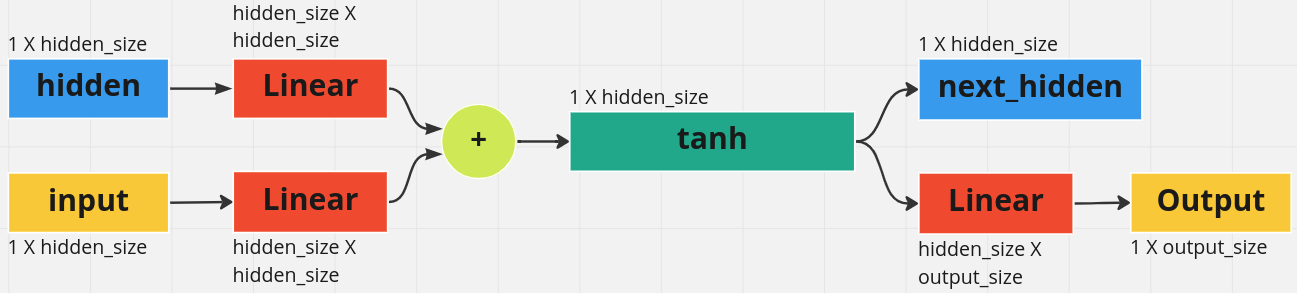

In [3]:
display.Image('imgs/rnn_cell.png')

Generate some fake samples

In [4]:
# Hyper Parameters
n_samples = 10 # generation 10 samples

# Create some fake data
# Each sample in the batch has 50 dimensions, as a 50-dim embedding
batch = torch.randn(n_samples, 50) 
# The output is a 10-dim space
target = torch.zeros(n_samples, 10)

In [5]:
print(batch.shape)

torch.Size([10, 50])


Run step by step

In [6]:
embed_layer = nn.Linear(50, 64) # embedding size is 50, hidden size is 64
emb = embed_layer(batch)

linear_layer = nn.Linear(64, 64) 
i2h = linear_layer(emb) # Linear transformation of the embedded vector

hidden = torch.zeros(emb.shape) 
h2h = linear_layer(hidden)   # Linear transformation of the hidden vector

combined = i2h + h2h    # Combine i2h and h2h by adding two together 

out = torch.tanh(combined) # Nonlinear activation

out_layer = nn.Linear(64, 10) # hidden size is 64, output size is 10
hidden = out
output = out_layer(out)

In [7]:
# print(emb.shape)
# print(i2h.shape)
# print(h2h.shape)
# print(combined.shape)
print(output)

tensor([[-1.8417e-01, -3.6585e-01,  9.7594e-02,  3.0113e-04, -1.7401e-01,
         -6.0177e-02,  8.6637e-02, -2.3155e-01, -7.8317e-02, -5.8632e-02],
        [-9.8612e-03, -3.1520e-01,  9.1807e-02,  1.0368e-01, -2.6956e-01,
          3.9124e-02, -1.2529e-01, -2.9518e-01,  7.5055e-02,  1.2544e-01],
        [ 2.1664e-01, -6.3822e-01,  9.9980e-02, -7.1095e-02, -6.2970e-02,
         -5.7725e-02,  9.1720e-02, -3.5364e-01,  1.1052e-01,  4.5492e-02],
        [ 6.8037e-02,  3.2874e-01, -3.3130e-01, -4.9432e-02, -2.2244e-01,
          1.0626e-01, -7.9228e-02, -8.4964e-02,  3.3136e-01, -2.2594e-01],
        [-1.8348e-01, -1.6341e-01, -7.9955e-02, -2.8147e-02, -2.3613e-01,
         -1.6423e-01,  2.8876e-02,  9.7065e-02, -2.1907e-01,  5.7349e-02],
        [-1.1058e-01, -4.9176e-01,  6.7694e-02, -1.1186e-01,  2.1758e-01,
         -2.6772e-01,  3.7867e-01, -2.1002e-01, -1.4763e-01,  2.0397e-01],
        [ 1.6115e-01, -1.6861e-01,  7.0360e-03,  3.7027e-01,  1.2386e-01,
         -3.5397e-01, -2.8621e-0

# Stack the cell to build the RNN model

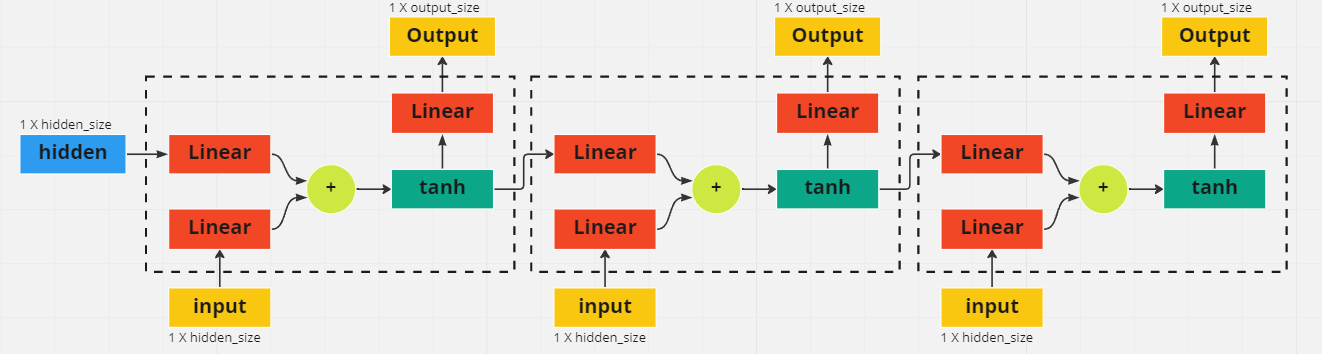

In [8]:
display.Image('imgs/simple_rnn.png')

Rewrite above rnn cell as a class

In [9]:
class SimpleRNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, embed_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.embed = nn.Linear(embed_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self, input):
        return torch.zeros(self.embed(input).shape)

    def forward(self, input, hidden):
        # convert the embed into 1 X hidden (1, hidden_size)
        emb = self.embed(input)

        # Linear transformation for both embedded input and hidden
        i2h = self.hidden(emb)
        h2h = self.hidden(hidden)

        # Combine using matrix adding
        combined = i2h + h2h

        # Activated using tanh function to get the next hidden
        # Use output linear transforamtion to get the desired output shape
        next_hidden = torch.tanh(combined)
        output = self.output(next_hidden)
        
        return next_hidden, output

In [10]:
# Create the rnn model
simple_rnn = SimpleRNN(embed_size=50, hidden_size=64, output_size=10) 

In [11]:
hidden = simple_rnn.init_hidden(batch) # initalize the hidden 

In [12]:
hidden, output = simple_rnn(batch, hidden) # get the output vector

In [13]:
print(output.shape)
print(output)

torch.Size([10, 10])
tensor([[-1.9474e-01,  4.4482e-02,  1.8929e-01, -1.4970e-01, -1.2199e-01,
          2.0468e-01,  1.2329e-01,  1.9461e-01, -1.1518e-01, -4.1090e-02],
        [-3.8605e-01, -5.1431e-02,  9.5742e-02, -2.4924e-01, -1.6251e-01,
         -9.4962e-02,  3.2785e-01,  3.7027e-01, -1.8302e-01,  2.3637e-02],
        [-1.2109e-01,  9.2790e-02,  1.0667e-01, -7.5990e-02,  2.3358e-01,
          9.3059e-02,  2.2099e-01,  2.8593e-01, -8.3277e-02,  1.2816e-01],
        [-2.0320e-01,  5.1442e-02, -9.8964e-02, -1.5557e-01, -1.1304e-01,
          8.6710e-02, -4.9656e-02,  3.6005e-01, -1.8694e-01, -1.6142e-01],
        [-2.5714e-01,  8.7283e-02,  2.0154e-01, -1.4937e-01, -3.5658e-01,
         -1.7920e-01,  2.5122e-03, -1.7317e-01, -7.7608e-02,  1.0884e-01],
        [-3.0468e-01, -1.5329e-01,  2.5955e-01, -6.7539e-02,  9.8750e-02,
         -1.1968e-03, -8.6618e-02,  6.5401e-02,  2.2201e-02,  2.4291e-01],
        [ 5.1864e-02, -1.5340e-01,  1.8679e-01, -2.2879e-01, -2.1249e-01,
          1

Train on the 10 sample dataset once

In [14]:
loss_fn = nn.MSELoss() # Define loss function

In [15]:
def train_step(batch, loss_fn, lr):
    hidden = simple_rnn.init_hidden(batch) # initialize the hidden 
    loss = 0 # initialize the loss
    
    # model gradient initalization
    simple_rnn.zero_grad()

    # Forward
    hidden, output = simple_rnn(batch, hidden)

    # Loss 
    loss = loss_fn(output, target)

    # backward
    loss.backward()

    # Update
    for p in simple_rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    
    return loss.item()

In [16]:
train_step(batch, loss_fn, lr=0.01)

0.03333855792880058

Train on all 10 samples with EPOCH times

In [17]:
EPOCH = 1000

for i in range(EPOCH):
    loss = train_step(batch, loss_fn, 0.005)

    if i % 50 == 0:
        print(f'{i}/{EPOCH}: Loss={loss}')

0/1000: Loss=0.03287237510085106
50/1000: Loss=0.023623133078217506
100/1000: Loss=0.01760421320796013
150/1000: Loss=0.013541982509195805
200/1000: Loss=0.010708753019571304
250/1000: Loss=0.008670938201248646
300/1000: Loss=0.007162163965404034
350/1000: Loss=0.006014676298946142
400/1000: Loss=0.005120447371155024
450/1000: Loss=0.004408374894410372
500/1000: Loss=0.0038306203205138445
550/1000: Loss=0.0033542632590979338
600/1000: Loss=0.0029561296105384827
650/1000: Loss=0.00261952867731452
700/1000: Loss=0.0023321756161749363
750/1000: Loss=0.0020848363637924194
800/1000: Loss=0.00187043403275311
850/1000: Loss=0.0016834498383104801
900/1000: Loss=0.0015195129672065377
950/1000: Loss=0.0013751109363511205


View the prediction

In [18]:
hidden = simple_rnn.init_hidden(batch)
_, preds = simple_rnn(batch, hidden)
print(preds)

tensor([[ 0.0174,  0.0436,  0.0201,  0.0244,  0.0331,  0.0312,  0.0104, -0.0357,
          0.0238, -0.0564],
        [-0.0530, -0.0255, -0.0115, -0.0236, -0.0050, -0.0489,  0.0708,  0.0560,
         -0.0126,  0.0199],
        [ 0.0140,  0.0532, -0.0108,  0.0305,  0.0792,  0.0157,  0.0474, -0.0091,
         -0.0022, -0.0044],
        [-0.0097,  0.0097, -0.0315, -0.0523,  0.0201,  0.0012, -0.0169, -0.0377,
         -0.0363, -0.0059],
        [ 0.0080,  0.0164,  0.0288, -0.0243, -0.0252, -0.0206, -0.0113, -0.0798,
          0.0062,  0.0009],
        [-0.0586, -0.0642,  0.0350, -0.0107,  0.0504,  0.0159, -0.0059, -0.0176,
         -0.0039,  0.0347],
        [ 0.0604, -0.0482,  0.0189, -0.0626, -0.0605,  0.0202, -0.0533, -0.0309,
         -0.0019,  0.0406],
        [-0.0366, -0.0103, -0.0381,  0.0295, -0.0482, -0.0183, -0.0180,  0.0206,
         -0.0377, -0.0055],
        [ 0.0308,  0.0189,  0.0107,  0.0225, -0.0461, -0.0394, -0.0549,  0.0465,
          0.0280, -0.0228],
        [ 0.0142, -

In [19]:
print(target)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
